In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = yf.download('^GSPC').reset_index()
df['Close']=df['Close'].astype("float")
df = df.rename(columns={"Close": "price", "Date":"date"})

df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = df['price-meanavge']/(df['price'] + df['meanavge'])
bins = [-0.125668, -0.03876, -0.003, 0.019717, 0.066601]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)


[*********************100%***********************]  1 of 1 completed


In [2]:
df.describe()

Open          High           Low         price     Adj Close  \
count  18086.000000  18086.000000  18086.000000  18086.000000  18086.000000   
mean     724.460830    755.562563    746.199692    751.175422    751.175422   
std      995.154128    982.202378    970.449292    976.687434    976.687434   
min        0.000000     20.959999     20.959999     20.959999     20.959999   
25%        0.000000     90.602499     89.115000     89.835001     89.835001   
50%      250.824997    252.980003    248.745003    250.900002    250.900002   
75%     1196.095001   1203.620026   1188.232544   1196.652466   1196.652466   
max     4804.509766   4818.620117   4780.040039   4796.560059   4796.560059   

             Volume      meanavge     meanvalue  price-meanavge         move%  
count  1.808600e+04  18086.000000  18086.000000    18086.000000  18086.000000  
mean   1.131903e+09    731.316139     19.859283       19.859283      0.012187  
std    1.728459e+09    947.462384     84.696433       84.696433      0.033342  
min    6.800000e+05     20.064806   -792.456947     -792.456947     -0.225668  
25%    1.088000e+07     88.696971     -0.928404       -0.928404     -0.003887  
50%    1.383550e+08    254.928664      4.633368        4.633368      0.017732  
75%    1.695600e+09   1179.530698     34.321620       34.321620      0.033714  
max    1.145623e+10   4443.160347    541.336686      541.336686      0.086601

In [3]:
df["Valuation"].value_counts()

Severely Overbought    8322
Neutral Overbought     4902
Neutral Oversold       3395
Severely Oversold      1149
Name: Valuation, dtype: int64

12:10:09 - cmdstanpy - INFO - Chain [1] start processing
12:10:26 - cmdstanpy - INFO - Chain [1] done processing


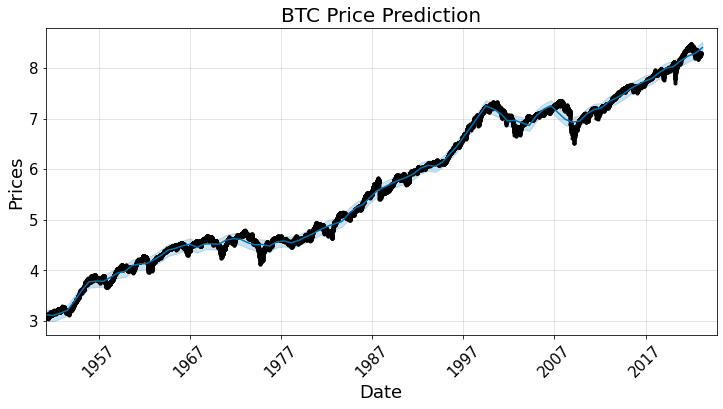

In [4]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "1951-03-15"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['1951-03-15', '2024-10-24'])) 
plt.show();

In [5]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","orange","red"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='S&P500 Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=False)
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/SPYcombo.html')

In [6]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","orange","red"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='S&P500 Buy Zones 2.0')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.update_traces(dict(marker_line_width=.01))
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/SPYbuyzones2.html')

In [7]:
df['status'] = df['status'].replace({'0': 'Under'})
df['status'] = df['status'].replace({'1': 'Over'})

In [8]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='S&P500 Under vs Over meanaverage')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.update_traces(dict(marker_line_width=.01))

fig.update_layout(showlegend=False)
fig.layout.template = 'seaborn'
fig.show()